# Принятие решений в бизнесе

Вместе с отделом маркетинга подготовили список гипотез для увеличения выручки.

Цель проекта:
- приоритизировать гипотезы, 
- запустить A/B-тест и проанализировать результаты.

Данные предосталены тремя датасетами:
- Файл /datasets/hypothesis.csv с 9 гипотезами по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort
- Файл с заказами во время A/B-теста /datasets/orders.csv 
- Файл с посещениями пользователей во время A/B-теста /datasets/visitors.csv

О качестве данных ничего не известно. Поэтому перед проверкой гипотез понадобится обзор данных.
Нужно проверить данные на ошибки и оцените их влияние на исследование. 

Таким образом, исследование пройдёт в 5 этапов:

- Ознакомление с данными
- Предобработка данных
- Приоритизация гипотез
- Анализ A/B-теста
- Общий вывод

## Загрузка данных

In [1]:
#загружаем библиотеки
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime, timedelta
from scipy import stats as st
import scipy.stats as stats

In [2]:
try:
    visits = pd.read_csv('/datasets/visitors.csv')
    orders = pd.read_csv('/datasets/orders.csv')
    hypothesis = pd.read_csv('/datasets/hypothesis.csv')
except:
    visits = pd.read_csv('C:\Python\datasets/visitors.csv')
    orders = pd.read_csv('C:\Python\datasets/orders.csv')
    hypothesis = pd.read_csv('C:\Python\datasets/hypothesis.csv')

## Ознакомление с данными

In [3]:
visits.head(5)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


**date** — дата;\
**group** — группа A/B-теста;\
**visitors** — количество пользователей в указанную дату в указанной группе A/B-теста

In [4]:
orders.head(5)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


**transactionId** — идентификатор заказа;\
**visitorId** — идентификатор пользователя, совершившего заказ;\
**date** — дата, когда был совершён заказ;\
**revenue** — выручка заказа;\
**group** — группа A/B-теста, в которую попал заказ.

Для удобства можно привести названия столбцов к строчному написанию

In [5]:
pd.options.display.max_colwidth = 110
display(hypothesis)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


**Hypothesis** — краткое описание гипотезы;\
**Reach** — охват пользователей по 10-балльной шкале;\
**Impact** — влияние на пользователей по 10-балльной шкале;\
**Confidence** — уверенность в гипотезе по 10-балльной шкале;\
**Efforts** — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Для удобства  так же можно привести названия столбцов к строчному написанию

In [6]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


In [7]:
visits.duplicated().sum()

0

В таблице визито видим дату в формате object, нужно будет перевести в формат даты.\
Явных дубликатов в таблице нет.\
Пропусков тоже нет

In [8]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [9]:
orders.duplicated().sum()

0

In [10]:
orders.describe()

,transactionId,visitorId,revenue
count,1.197000e+03,1.197000e+03,1.197000e+03
mean,2.155621e+09,2.165960e+09,8.348006e+03
std,1.229085e+09,1.236014e+09,3.919113e+04
min,1.062393e+06,5.114589e+06,5.000000e+01
25%,1.166776e+09,1.111826e+09,1.220000e+03
50%,2.145194e+09,2.217985e+09,2.978000e+03
75%,3.237740e+09,3.177606e+09,8.290000e+03
max,4.293856e+09,4.283872e+09,1.294500e+06


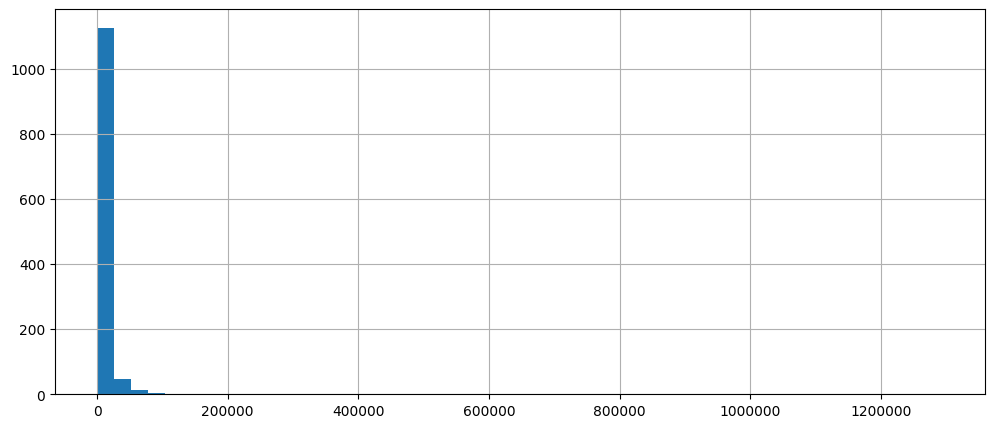

In [11]:
orders['revenue'].hist(bins=50, figsize = (12,5))
plt.ticklabel_format(style='plain')

In [12]:
print('Максимальный заказ', orders['revenue'].max())
print('Минимальный заказ', orders['revenue'].min())
print('Медианный заказ', orders['revenue'].median())

Максимальный заказ 1294500
Минимальный заказ 50
Медианный заказ 2978.0


В таблице заказов так же дата в формате object, нужно будет перевести в формат даты.\
Явных дубликатов и пропусков в таблице нет\
Видим довольно большой разброс в суммах заказов. от 50 аж до 1 294 500\
Будем учитавать аномальные значения во время анализа результатов теста. Они могут сместить оценку.

In [13]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


С датасетом с гипозами все в порядке.

### **Вывод:**
- Данные чистые, пропусков и дубликатов нет
- Нет отрицательных значений, где их быть не может. Данные собраны корректно

На этапе предобработки:
- Необходимо привести формат даты к верному типу.
- Для удобства привести названия столбцов к строчному написанию (orders и hypothesis)

## Предобработка данных

### Преобразования

In [14]:
# приводим дату к нужному формату
visits['date'] = pd.to_datetime(visits['date'])
orders['date'] = pd.to_datetime(orders['date'])

In [15]:
#приводим названия столбцов
hypothesis.columns = hypothesis.columns.str.lower()
orders = orders.rename(columns={'transactionId': 'transaction_id', 'visitorId':'visitor_id'})

In [16]:
visits.info() #проверка

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [17]:
orders.info() #проверка

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


### Проверка дат

In [18]:
print('Минимальная дата в таблице посещений', visits['date'].dt.date.min())
print('Максимальная дата в таблице посещений', visits['date'].dt.date.max())

Минимальная дата в таблице посещений 2019-08-01
Максимальная дата в таблице посещений 2019-08-31


In [19]:
print('Минимальная дата в таблице заказов', orders['date'].dt.date.min())
print('Максимальная дата в таблице заказов', orders['date'].dt.date.max())

Минимальная дата в таблице заказов 2019-08-01
Максимальная дата в таблице заказов 2019-08-31


**Вывод:** Даты совпадают, все верно. Лишние записи отсутствуют.\
Получаем, что эксперимент запущен 1 августа 2019 года и длится 31 день.

### Проверка кол-ва пользователей в группах теста

In [20]:
visits.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [21]:
group_visits = visits.groupby('group', as_index=False).agg({'visitors':'sum'})
group_visits

,group,visitors
0,A,18736
1,B,18916


In [22]:
print(f'Разница между группами {group_visits.visitors[1] - group_visits.visitors[0]} человек')
print(f'Относительное различие количества пользователей равно {(1-(group_visits.visitors[0]/group_visits.visitors[1])):.2%}')
#f'Я изучаю {prog_language.upper()} уже {day + 1}-й день'

Разница между группами 180 человек
Относительное различие количества пользователей равно 0.95%


**Вывод:** 
Кол-во пользователей в контрольной и тестовой группах различается на 1%. Что может отразится на анализе результатов теста. Будем учитывать это при анализе

In [23]:
orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [24]:
id_a = orders[orders.group == 'A']['visitor_id'].unique()
id_b = orders[orders.group == 'B']['visitor_id'].unique()

In [25]:
len(list(set(id_a) & set(id_b)))

58

**Вывод:**\
Получаем 58 пользователей, которые делали заказы в обеих группах. При идеальном проведении А/В теста такого быть не должно.

### Вывод по предобработке

- Привели формат даты к верному типу.
- Для удобства привели названия столбцов к строчному написанию
- Проверили совпадение временного интервала в таблице посещений и заказов
- Выявили разницу кол-ва пользователей в контрольной и тестовой группах - 1%. 
- Выявили 58 пользователей, которые делали заказы в обеих группах. 

Удаление лишних пользователей для приведения к одинаковому кол-ву в обоих группах невозможно - т.к. это повлияет на конверсию. Id пользователей у нас имеются только в таблице с заказами, в то время как в таблице посещений лишь общее число пользователей по дням. 

## Приоритизация гипотез

In [26]:
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


### Фреймворк ICE для приоритизации гипотез. Сортировка по убыванию приоритета.

In [27]:
hypothesis['ICE'] = (hypothesis.impact * hypothesis.confidence)/hypothesis.efforts

In [28]:
display((hypothesis[['hypothesis', 'ICE']].sort_values(by = 'ICE', ascending=False)).round(2))

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


**Вывод:** Топ-3 гипотезы по ICE - 8, 0 и 7:
- 8. Запустить акцию, дающую скидку на товар в день рождения
- 0. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
- 7. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок

### Фреймворк RICE для приоритизации гипотез. Сортировка по убыванию приоритета.

In [29]:
hypothesis['RICE'] = (hypothesis.reach * hypothesis.impact * hypothesis.confidence)/hypothesis.efforts

In [30]:
display((hypothesis[['hypothesis', 'RICE']].sort_values(by = 'RICE', ascending=False)).round(2))

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


**Вывод:** Топ-4 гипотезы по RICE - 7, 2 0 и 6:
- 7. Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
- 2. Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
- 0. Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей	
- 6. Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию

### Анализ изменений
Укажите, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясните, почему так произошло.

In [31]:
hyp = (hypothesis.sort_values(by = 'ICE', ascending=False)).round(2)
hyp.style.background_gradient(cmap='coolwarm').set_precision(2)

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.00
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.00
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.00
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.00
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.00


**Вывод** 
- При приоритизации методом RICE появляется пораметр reach - охват. В 7й гипотезе оценка этого параметра максимальная. За счет этого, при методе RICE эта гипотеза выходит на первое место. 

- Лидирующая гипотеза по ICE (8) имеет высокие оценки в impact и confident - т.к. акция на день рождения конечно же сильно повлияет на пользователей с высокой вероятностью. Однако охват очень маленький. На короткой дистанции, только малая часть пользователей успеет получить скидку. Собрать 2 контрольные группы будет долго и сложно.

- Лидирующая гипотеза по RICE (7) имеет довольно хорошие показатели во всех столбцах. Добавление формы подписки для сбора базы клиентов для рассылки иммет большой охват (не будет проблем с набором группы), высокую оценку по влиянию на пользователей и высокую оценку уверенности в гипотезе. В то же время среднюю стоимость тестирования гипотезы.

### Вывод по разделу приоритизация гипотез

По результатам примененных методов можно отдать приоритет гипотезе №7:\
**"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок"**

## Анализ A/B-теста

In [32]:
visits.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [33]:
orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [34]:
# массив уникальных пар значений дат и групп теста
dates_groups = orders[['date','group']].drop_duplicates() 

In [35]:
# cобераем агрегированные кумулятивные по дням данные о заказах
orders_agg = (
    dates_groups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
    .agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}), axis=1)
    .sort_values(by=['date','group']) 
)

In [36]:
orders_agg.head()

,date,group,transaction_id,visitor_id,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874


In [37]:
# cобераем агрегированные кумулятивные по дням данные о посетителях
visitors_agg = (
    dates_groups.apply(lambda x: visits[np.logical_and(visits['date'] <= x['date'], visits['group'] == x['group'])]
    .agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1)
    .sort_values(by=['date','group']) 
)

In [38]:
visitors_agg.head()

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


In [39]:
# объединяем обе таблицы в одну
cumulative_data = orders_agg.merge(visitors_agg, left_on=['date', 'group'], right_on=['date', 'group'])
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

display(cumulative_data.head(5)) 

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


### График кумулятивной выручки по группам.

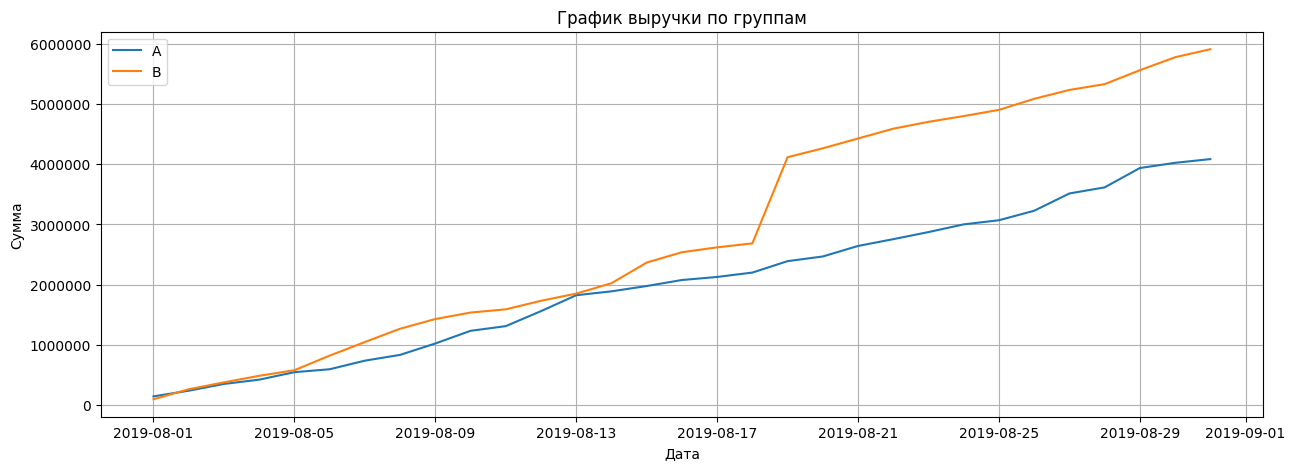

In [40]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulative_revenue_a = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulative_revenue_b = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

plt.figure(figsize=(15, 5))
plt.ticklabel_format(style='plain')
plt.grid()
plt.title('График выручки по группам')
plt.xlabel('Дата')
plt.ylabel('Сумма')

# Строим график выручки группы А
plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue'], label='B')

plt.legend();

**Вывод:** Выручка почти равномерно увеличивается в течение всего теста.
График выручки группы B в одной из точек очень резко растет. Это может быть из-за всплесках числа заказов, либо о появлении очень дорогих заказов в выборке.

### График кумулятивного среднего чека по группам. 

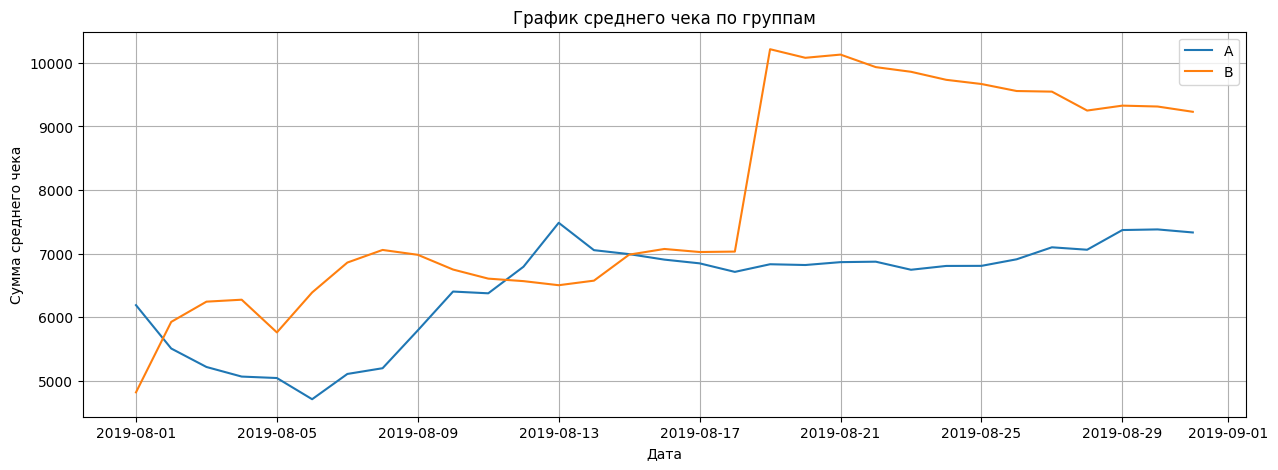

In [41]:
plt.figure(figsize=(15, 5))
plt.ticklabel_format(style='plain')
plt.grid()
plt.title('График среднего чека по группам')
plt.xlabel('Дата')
plt.ylabel('Сумма среднего чека')

plt.plot(cumulative_revenue_a['date'], cumulative_revenue_a['revenue']/cumulative_revenue_a['orders'], label='A')
plt.plot(cumulative_revenue_b['date'], cumulative_revenue_b['revenue']/cumulative_revenue_b['orders'], label='B')
plt.legend();

**Вывод:**
Средний чек становится более равномерным ближе к концу теста: ниже для группы A и выше для группы B. 
Сильный всплеск на графике может быть обусловлен крупным заказом (заказами) в группе B в районе 18-19 августа 

### График относительного изменения кумулятивного среднего чека группы B к группе A.

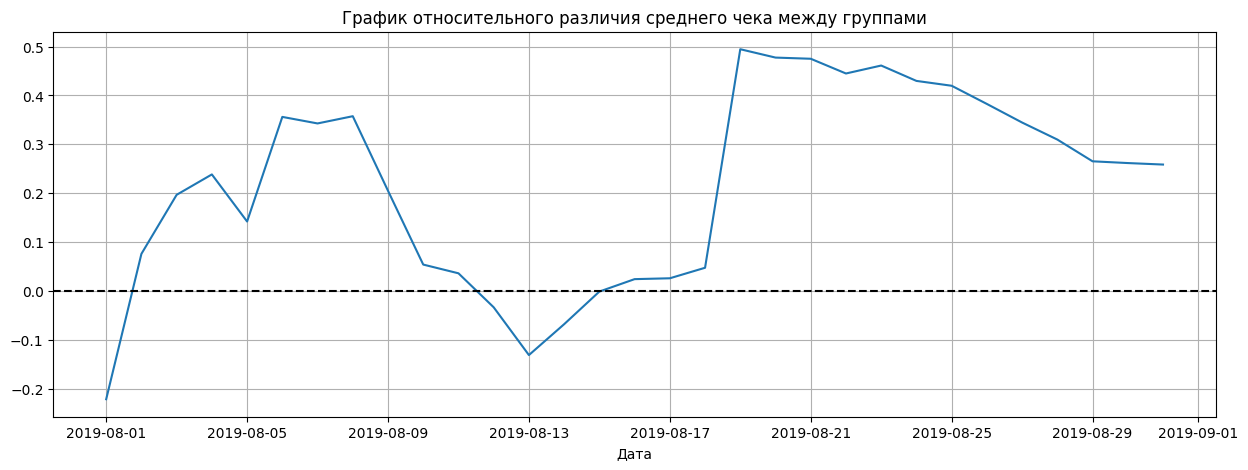

In [42]:
# собираем данные в одном датафрейме
merged_cumulative_revenue = cumulative_revenue_a.merge(cumulative_revenue_b, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.figure(figsize=(15, 5))
plt.grid()
plt.title('График относительного различия cреднего чека между группами')
plt.xlabel('Дата')

plt.plot(merged_cumulative_revenue['date'], 
         (merged_cumulative_revenue['revenueB']/merged_cumulative_revenue['ordersB'])/
         (merged_cumulative_revenue['revenueA']/merged_cumulative_revenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--');

**Вывод:**
График различия между группами резко «скачет». Причина - крупные заказы и выбросы. Но практически всегда результаты группы B лучше группы А.

### График кумулятивной конверсии по группам.

In [43]:
cumulative_data.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


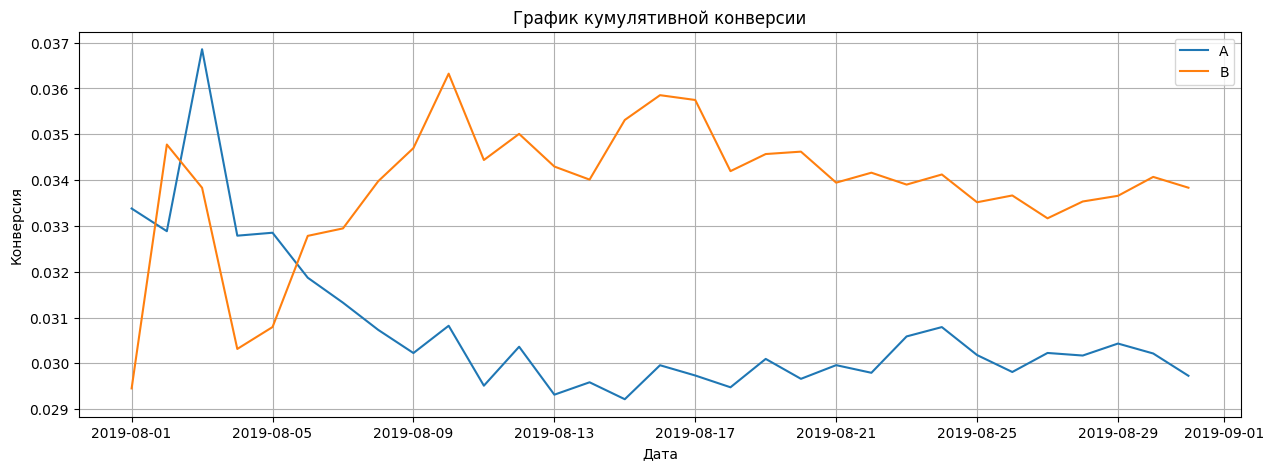

In [44]:
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']

# отделяем данные по группе A
cumulative_data_a = cumulative_data[cumulative_data['group']=='A']

# отделяем данные по группе B
cumulative_data_b = cumulative_data[cumulative_data['group']=='B']

# строим графики
plt.figure(figsize=(15, 5))
plt.grid()
plt.title('График кумулятивной конверсии')
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.plot(cumulative_data_a['date'], cumulative_data_a['conversion'], label='A')
plt.plot(cumulative_data_b['date'], cumulative_data_b['conversion'], label='B')
plt.legend();


Вначале теста видим сильные колебания. Но затем конверсия группы B вырвалась вперёд и зафиксировалась, а конверсия группы А просела и также зафиксировалась.

### График относительного изменения кумулятивной конверсии группы B к группе A..

In [45]:
merged_cumulative_conversions = (
    cumulative_data_a[['date','conversion']]
    .merge(cumulative_data_b[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
)

In [46]:
merged_cumulative_conversions.head()

,date,conversionA,conversionB
0,2019-08-01,0.033380,0.029453
1,2019-08-02,0.032885,0.034776
2,2019-08-03,0.036856,0.033833
3,2019-08-04,0.032787,0.030315
4,2019-08-05,0.032851,0.030793


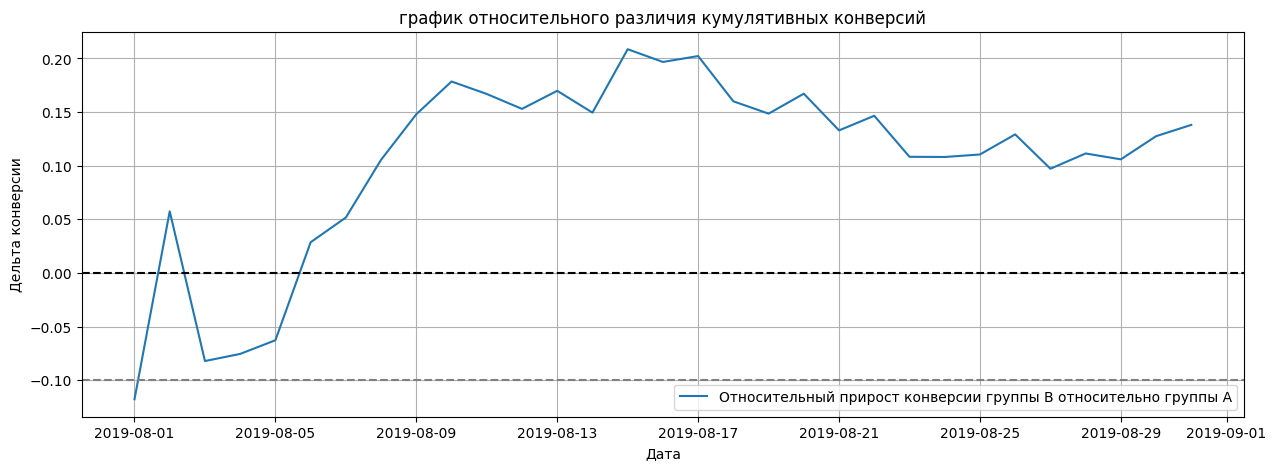

In [47]:
plt.figure(figsize=(15, 5))
plt.grid()
plt.title('график относительного различия кумулятивных конверсий')
plt.xlabel('Дата')
plt.ylabel('Дельта конверсии')
plt.plot(
    merged_cumulative_conversions['date'], 
    merged_cumulative_conversions['conversionB']/merged_cumulative_conversions['conversionA']-1, 
    label="Относительный прирост конверсии группы B относительно группы A"
)
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--');

В начале теста группа B проигрывала группе A, затем вырвалась вперёд и зафиксировалась выше группы А.

### Точечный график количества заказов по пользователям.

In [48]:
orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [49]:
orders_by_users = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
orders_by_users.columns = ['userId', 'orders']

display(orders_by_users.sort_values(by='orders', ascending=False).head(5))

,userId,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5


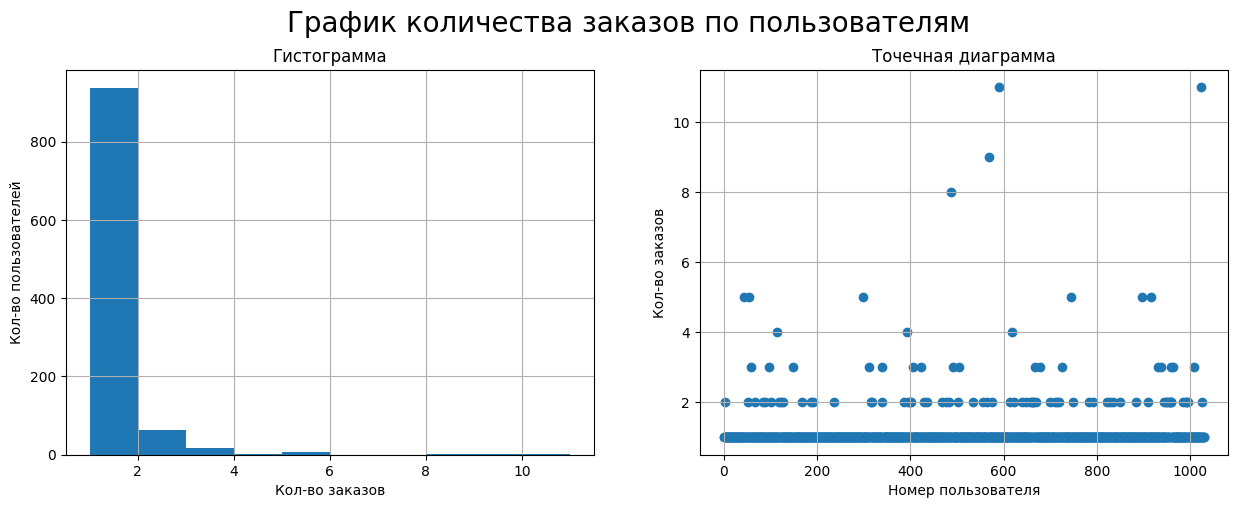

In [50]:
x_values = pd.Series(range(0, len(orders_by_users)))

fig, (ax0,ax1) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax0.grid(True)
ax0.set_title('Гистограмма')
ax0.hist(orders_by_users['orders'])
ax0.set_xlabel('Кол-во заказов')
ax0.set_ylabel('Кол-во пользователей')
ax1.grid(True)
ax1.set_title('Точечная диаграмма')
ax1.scatter(x_values, orders_by_users['orders'])
ax1.set_xlabel('Номер пользователя')
ax1.set_ylabel('Кол-во заказов')
fig.suptitle('График количества заказов по пользователям',
             y = 1,
             fontsize = 20);

На графиках видно, что большинство пользователей делают не более 2х заказов. Узнаем более точные пороги с помощью расчета 95-го и 99-го перцентиля

### 95-й и 99-й перцентили количества заказов на пользователя. Выбор границы для определения аномальных пользователей.

In [51]:
print(np.percentile(orders_by_users['orders'], [95, 99]))

[2. 4.]


Не более 5% пользователей оформили больше 2х заказов. И всего лишь 1% - больше 4х

**Вывод:**
Разумно выбрать 2 заказа на одного пользователя за верхнюю границу числа заказов, и отсеять аномальных пользователей по ней

### Точечный график стоимостей заказов.

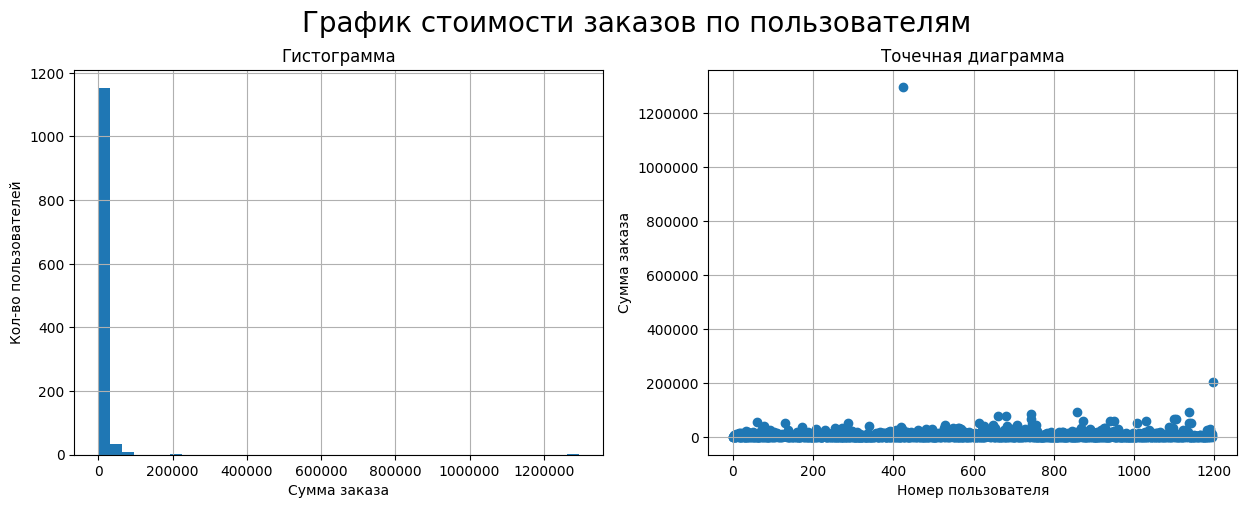

In [52]:
x_values = pd.Series(range(0, len(orders['revenue'])))

fig, (ax0,ax1) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
plt.ticklabel_format(style='plain')
ax0.grid(True)
ax0.set_title('Гистограмма')
ax0.hist(orders['revenue'], bins=40)
ax0.set_xlabel('Сумма заказа')
ax0.set_ylabel('Кол-во пользователей')
ax0.ticklabel_format(style='plain')
ax1.grid(True)
ax1.set_title('Точечная диаграмма')
ax1.scatter(x_values, orders['revenue'])
ax1.set_xlabel('Номер пользователя')
ax1.set_ylabel('Сумма заказа')
fig.suptitle('График стоимости заказов по пользователям',
             y = 1,
             fontsize = 20);

In [53]:
print('Максимальный заказ', orders['revenue'].max())
print('Минимальный заказ', orders['revenue'].min())
print('Медианный заказ', orders['revenue'].median())

Максимальный заказ 1294500
Минимальный заказ 50
Медианный заказ 2978.0


### 95-й и 99-й перцентили стоимости заказов. Выбор границы для определения аномальных заказов.

In [54]:
print(np.percentile(orders['revenue'], [95, 99]))

[28000.  58233.2]


5% заказов больше 28 000, и только 1% больше 58 233. 

**Вывод:**
Разумно выбрать сумму заказа в 28 000 за верхнюю границу и отсеять аномальные заказы по ней

### Статистическая значимость различий в среднем количестве заказов между группами по «сырым» данным. 

Нулевая гипотеза: различий в среднем количестве заказов между группами нет. \
Альтернативная: различия в среднем между группами есть.

#### Подготовка данных

In [55]:
visits.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [56]:
# считаем количество посещений в группе А с накоплением
visitors_daily_a = visits[visits['group'] == 'A'][['date', 'visitors']]
visitors_daily_a.columns = ['date', 'visitors_per_date_a']

visitors_cummulative_a = visitors_daily_a.apply(
    lambda x: visitors_daily_a[visitors_daily_a['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_a': 'sum'}
    ),
    axis=1,
)
visitors_cummulative_a.columns = ['date', 'visitors_cum_a']
visitors_cummulative_a.head()

,date,visitors_cum_a
0,2019-08-01,719
1,2019-08-02,1338
2,2019-08-03,1845
3,2019-08-04,2562
4,2019-08-05,3318


In [57]:
# считаем количество посещений в группе B с накоплением
visitors_daily_b = visits[visits['group'] == 'B'][['date', 'visitors']]
visitors_daily_b.columns = ['date', 'visitors_per_date_b']

visitors_cummulative_b = visitors_daily_b.apply(
    lambda x: visitors_daily_b[visitors_daily_b['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_b': 'sum'}
    ),
    axis=1,
)
visitors_cummulative_b.columns = ['date', 'visitors_cum_b']
visitors_cummulative_b.head()

,date,visitors_cum_b
31,2019-08-01,713
32,2019-08-02,1294
33,2019-08-03,1803
34,2019-08-04,2573
35,2019-08-05,3280


In [58]:
orders.head()

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [59]:
# считаем кол-во заказов и выручку по дням с накоплением для группы А
orders_daily_a = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_daily_a.columns = ['date', 'orders_per_date_a', 'revenue_per_date_a']

orders_cummulative_a = orders_daily_a.apply(
    lambda x: orders_daily_a[orders_daily_a['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_a': 'sum', 'revenue_per_date_a': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_cummulative_a.columns = ['date','orders_cum_a','revenue_cum_a']
orders_cummulative_a.head()

,date,orders_cum_a,revenue_cum_a
0,2019-08-01,24,148579
1,2019-08-02,44,242401
2,2019-08-03,68,354874
3,2019-08-04,84,425699
4,2019-08-05,109,549917


In [60]:
# считаем кол-во заказов и выручку по дням с накоплением для группы В

orders_daily_b = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_daily_b.columns = ['date', 'orders_per_date_b', 'revenue_per_date_b']

orders_cummulative_b = orders_daily_b.apply(
    lambda x: orders_daily_b[orders_daily_b['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_b': 'sum', 'revenue_per_date_b': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_cummulative_b.columns = ['date','orders_cum_b','revenue_cum_b']
orders_cummulative_b.head()

,date,orders_cum_b,revenue_cum_b
0,2019-08-01,21,101217
1,2019-08-02,45,266748
2,2019-08-03,61,380996
3,2019-08-04,78,489567
4,2019-08-05,101,581995


In [61]:
group_data = (
    orders_daily_a.merge(
        orders_daily_b, left_on='date', right_on='date', how='left'
    )
    .merge(orders_cummulative_a, left_on='date', right_on='date', how='left')
    .merge(orders_cummulative_b, left_on='date', right_on='date', how='left')
    .merge(visitors_daily_a, left_on='date', right_on='date', how='left')
    .merge(visitors_daily_b, left_on='date', right_on='date', how='left')
    .merge(visitors_cummulative_a, left_on='date', right_on='date', how='left')
    .merge(visitors_cummulative_b, left_on='date', right_on='date', how='left')
)
group_data['date'] = group_data.date.dt.date
group_data.head(10).T

,0,1,2,3,4,5,6,7,8,9
date,2019-08-01,2019-08-02,2019-08-03,2019-08-04,2019-08-05,2019-08-06,2019-08-07,2019-08-08,2019-08-09,2019-08-10
orders_per_date_a,24,20,24,16,25,18,18,16,16,16
revenue_per_date_a,148579,93822,112473,70825,124218,48484,142417,96279,188506,210495
orders_per_date_b,21,24,16,17,23,28,24,27,25,23
revenue_per_date_b,101217,165531,114248,108571,92428,242342,225334,220918,160812,107802
orders_cum_a,24,44,68,84,109,127,145,161,177,193
revenue_cum_a,148579,242401,354874,425699,549917,598401,740818,837097,1025603,1236098
orders_cum_b,21,45,61,78,101,129,153,180,205,228
revenue_cum_b,101217,266748,380996,489567,581995,824337,1049671,1270589,1431401,1539203
visitors_per_date_a,719,619,507,717,756,667,644,610,617,406


In [62]:
# считаем число совершённых заказов по пользователям в каждой группе
orders_by_users_a = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_a.columns = ['userId', 'orders']

orders_by_users_b = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_b.columns = ['userId', 'orders'] 

In [63]:
# создаем выборку, где каждый элемент — число заказов определённого пользователя, в том числе ноль по группе А
# число элементов — это количество пользователей, сумма всех элементов — количество заказов.
sample_a = (pd.concat([orders_by_users_a['orders'],
            pd.Series(0, index=np.arange(group_data['visitors_per_date_a'].sum() - len(orders_by_users_a['orders'])),
                      name='orders')],axis=0)
          )
sample_a.sample(5)

8946     0
8471     0
4389     0
12459    0
12300    0
Name: orders, dtype: int64

In [64]:
# создаем выборку, где каждый элемент — число заказов определённого пользователя, в том числе ноль по группе В
# число элементов — это количество пользователей, сумма всех элементов — количество заказов.
sample_b = (pd.concat([orders_by_users_b['orders'],
            pd.Series(0, index=np.arange(group_data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])),
                      name='orders')],axis=0)
          )
sample_b.sample(5)

9954     0
10178    0
2346     0
9700     0
9150     0
Name: orders, dtype: int64

### Статистическая значимость различий в среднем количестве заказов между группами по «сырым» данным.

**Нулевая гипотеза:** Различий в среднем кол-ве заказов между группами нет. \
**Альтернативная гипотеза:** различия в среднем кол-ве заказов между группами есть.

In [65]:
print("p-value равно {0:.8f}".format(stats.mannwhitneyu(sample_a, sample_b)[1]))
print("Разница между группами {0:.3f}".format(sample_b.mean() / sample_a.mean() - 1))

p-value равно 0.01679236
Разница между группами 0.138


**Вывод по сырым данным:** \
P-value = 0.017, т.е. меньше 0.05 (статистическая значимость). Значит отвергаем нулевую гипотезу о том, что статистически значимых различий в среднем количестве заказов заказов между группами нет. Количество заказов в группе B на 13,8% больше

### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным.

**Нулевая гипотеза:** различий в среднем чеке между группами нет. \
**Альтернативная гипотеза:** различия в среднем чеке между группами есть.

In [66]:
print('P-value равно {0:.8f}'
      .format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Разница между группами {0:.3f}'
      .format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

P-value равно 0.72929099
Разница между группами 0.259


**Вывод по сырым данным:** \
P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Впрочем, средний чек группы B значительно выше среднего чека группы A - на 25.9%

### Статистическая значимость различий в среднем количестве заказов между группами по «очищенным» данным.

#### Очистка данных

In [67]:
users_with_many_orders = pd.concat(
    [orders_by_users_a[orders_by_users_a['orders'] > 2]['userId'],
     orders_by_users_b[orders_by_users_b['orders'] > 2]['userId'],],axis=0,
    )
users_with_many_orders.count()

24

24 пользователя имеют сильные отклонения в количестве заказов

In [72]:
users_with_expensive_orders = orders[orders['revenue'] > 28000]['visitor_id']
users_with_expensive_orders.count()

60

У 60 пользователей присутствуют аномально большие заказы

In [75]:
abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)
abnormal_users.count()

74

Получаем 74 уникальных пользователя, котрые имеют аномальное кол-во заказов или сумму заказов.

In [76]:
# фильтруем и создаем выборку, где каждый элемент — число заказов определённого пользователя по группе А
filter_sample_a = pd.concat(
    [
        orders_by_users_a[
            np.logical_not(orders_by_users_a['userId'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                group_data['visitors_per_date_a'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [77]:
# фильтруем и создаем выборку, где каждый элемент — число заказов определённого пользователя по группе В
filter_sample_b = pd.concat(
    [
        orders_by_users_b[
            np.logical_not(orders_by_users_b['userId'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                group_data['visitors_per_date_b'].sum() - len(orders_by_users_b['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

#### Тест

**Нулевая гипотеза:** Различий в среднем кол-ве заказов между группами нет. \
**Альтернативная гипотеза:** различия в среднем кол-ве заказов между группами есть.

In [78]:
print('P-value равно {0:.3f}'.format(stats.mannwhitneyu(filter_sample_a, filter_sample_b)[1]))
print('Разница в группах равна {0:.3f}'.format(filter_sample_b.mean()/filter_sample_a.mean()-1)) 

P-value равно 0.016
Разница в группах равна 0.167


Результаты по среднему количеству заказов практически не изменились.

*Было:\
p-value равно 0.017\
Разница между группами 0.138*

P-value по прежнему меньше 0.05. Значит отвергаем нулевую гипотезу о равенстве в среднем количестве заказов в группах. Количество заказов в группе B по очищенным данным на 16.7% больше.

### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным. 

**Нулевая гипотеза:** различий в среднем чеке между группами нет. \
**Альтернативная гипотеза:** различия в среднем чеке между группами есть.

In [79]:
print(
    'P-value равно {0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'],
        )[1]
    )
)
print(
    "Разница между группами равна {0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

P-value равно 0.738
Разница между группами равна -0.020


*Было:\
P-value равно 0.729\
Разница между группами 0.259*

P-value практически не изменился, и он значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет.
Однако разница между группами изменилась с 25.9% до -0.02%. Т.е. по очищенным данным средний чек в группе B на 2% хуже, чем в группе A

### Вывод


- Статистически значимое различие по среднему количеству заказов между группами есть и по «сырым» данным и по данным после фильтрации аномалий. В среднем в группе В заказов на 16.7% больше (по очищенным данным)
- Статистически значимых различий по среднему чеку между группами нет ни по «сырым» данным , ни по данным после фильтрации аномалий. Однако можно увидеть, как аномально большые заказы влияют на оценку. По сырым данным среднего чека группа В лидирует на 25.9%, а по очищенным проигрывает на 2%.

## Общий вывод

*Примите решение по результатам теста и объясните его. Варианты решений: 1. Остановить тест, зафиксировать победу одной из групп. 2. Остановить тест, зафиксировать отсутствие различий между группами. 3. Продолжить тест.*

- График различия конверсии между группами сообщает, что результаты группы B лучше группы A примерно на 4%, показатели зафиксировались около среднего значения. 
- График различия среднего чека так же лучше у группы В. Однако статистической разницы в среднем чеке нет. Нельзя принимать решение о различии в результатах теста только на основе относительного изменения.
- Статистически значимое различие по среднему количеству заказов между группами есть. В группе В заказов в среднем на 16.7% больше.

Таким образом А/В тест показал улучшения в среднем количестве заказов пользователей, однако не повлиял на средний чек пользователей. 

Исходя из обнаруженных фактов, тест можно остановить и признать успешным, если его целью было именно увеличесния числа заказов.

Так же не стоит забывать о выявленные ошибках в делении трафика. Мы выявили разницу кол-ва пользователей в контрольной и тестовой группах - около 1%, а так же 58 пользователей, которые делали заказы в обеих группах. 